In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
!mkdir dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# #Get the dataset
# !unzip /content/drive/MyDrive/temp/balanced_dataset.zip -d /content/dataset

In [5]:
!unzip /content/drive/MyDrive/temp/pywaveletted_roi_dataset.zip -d /

Archive:  /content/drive/MyDrive/temp/pywaveletted_roi_dataset.zip
   creating: /content/split_roi_dataset/
   creating: /content/split_roi_dataset/test/
   creating: /content/split_roi_dataset/test/Pneumonia-Viral/
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (1340).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (521).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (1009).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (1229).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (1376).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (382).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (630).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumonia-Viral (791).jpg  
  inflating: /content/split_roi_dataset/test/Pneumonia-Viral/Pneumon

InceptionV3 Model

In [6]:
# Initial imports
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)

In [8]:
# Create the InceptionV3 model
def create_model():
    # Load InceptionV3 with pretrained weights
    # Note: InceptionV3 requires 299x299 input size
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)  # InceptionV3 requires 299x299
    )

    # Unfreeze some layers for fine-tuning
    for layer in base_model.layers[-40:]:  # Unfreeze more layers than VGG16
        layer.trainable = True

    # Add custom classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # First dense block
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Second dense block
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Output layer
    predictions = Dense(3, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile with appropriate learning rate
    model.compile(
        optimizer=Adam(learning_rate=5e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Set up data generators with augmentation
def setup_data_generators():
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.15,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1.0/255)

    train_dir = '/content/split_roi_dataset/train'
    val_dir = '/content/split_roi_dataset/val'
    test_dir = '/content/split_roi_dataset/test'

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),  # InceptionV3 input size
        batch_size=32,
        class_mode='categorical'
    )

    validation_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(299, 299),  # InceptionV3 input size
        batch_size=32,
        class_mode='categorical'
    )

    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(299, 299),  # InceptionV3 input size
        batch_size=32,
        class_mode='categorical'
    )

    return train_generator, validation_generator, test_generator

In [9]:
# Training configuration
def train_model(model, train_generator, validation_generator):
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            'best_inceptionv3_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=100,
        callbacks=callbacks,
        verbose=1
    )

    return history

In [10]:
# Model evaluation
def evaluate_model(model, test_generator):
    # Get predictions
    test_generator.reset()
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Calculate metrics
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns

    # Plot confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(
        true_classes,
        predicted_classes,
        target_names=class_labels
    ))

# Count images in folders (utility function)
def count_images_in_folder(folder_path):
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp')
    image_count = 0
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(image_extensions):
            image_count += 1
    return image_count

# Test accuracy calculation
def calculate_test_accuracy(model, test_generator):
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f'Test accuracy: {test_accuracy * 100:.2f}%')
    return test_loss, test_accuracy

In [11]:
# # Create and setup everything
model = create_model()
train_generator, validation_generator, test_generator = setup_data_generators()

# Train
history = train_model(model, train_generator, validation_generator)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 3969 images belonging to 3 classes.
Found 495 images belonging to 3 classes.
Found 499 images belonging to 3 classes.
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4460 - loss: 1.5973
Epoch 1: val_accuracy improved from -inf to 0.42828, saving model to best_inceptionv3_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.4465 - loss: 1.5958 - val_accuracy: 0.4283 - val_loss: 1.0457 - learning_rate: 5.0000e-05
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.5879 - loss: 1.1663
Epoch 2: val_accuracy improved from 0.42828 to 0.63030, saving model to best_inceptionv3_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 109s 836ms/step - accuracy: 0.5880 - loss: 1.1658 - val_accuracy: 0.6303 - val_loss: 0.7999 - learning_rate: 5.0000e-05
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.6318 - loss: 0.9854
Epoch 3: val_accuracy did not improve from 0.63030
125/125 ━━━━━━━━━━━━━━━━━━━━ 102s 787ms/step - accuracy: 0.6318 - loss: 0.9851 - val_accuracy: 0.5475 - val_loss: 1.0420 - learning_rate: 5.0000e-05
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 861ms/step - accuracy: 0.7230 - loss: 0.6304
Test accuracy: 74.55%
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 586ms/step


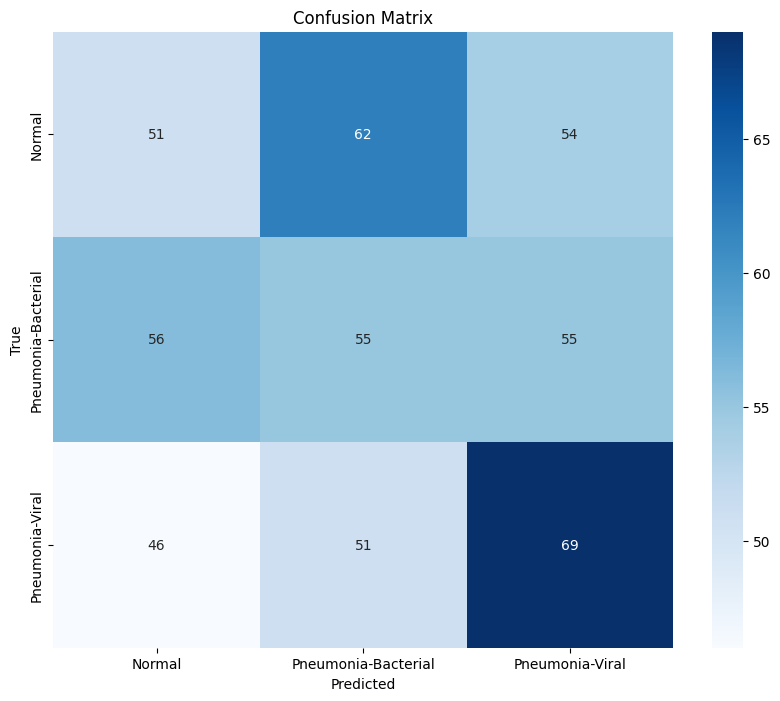


Classification Report:
                     precision    recall  f1-score   support

             Normal       0.33      0.31      0.32       167
Pneumonia-Bacterial       0.33      0.33      0.33       166
    Pneumonia-Viral       0.39      0.42      0.40       166

           accuracy                           0.35       499
          macro avg       0.35      0.35      0.35       499
       weighted avg       0.35      0.35      0.35       499



In [12]:
# Evaluate
test_loss, test_accuracy = calculate_test_accuracy(model, test_generator)
evaluate_model(model, test_generator)

In [13]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.7230 - loss: 0.6187
Test accuracy: 74.55%
